# %% [markdown]
# # Pronóstico de Variables Macroeconómicas con Banxico API
# **Proyecto Final - Modelos no lineales para pronóstico**
# 
# ## Objetivo
# Desarrollar un modelo de pronóstico usando series de tiempo del Banco de México para predecir el tipo de cambio USD/MXN, incorporando variables macroeconómicas como TIIE, UDIS, y CETES.

# %% [markdown]

## 1. Setup e Imports

In [67]:
# %%
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Import custom functions
from data_acquisition import (
    GetBanxicoToken,
    FetchSeriesData,
    FetchMultipleSeries,
    MergeSeriesOnDate,
    SaveDataToCSV
)

from data_processing import (
    HandleMissingValues,
    HandleOutliers,
    CreateLagFeatures,
    CreateRollingFeatures,
    CalculateReturns
)

from feature_engineering import (
    CreateTimeSeriesWindows,
    ScaleData,
    InverseScaleData,
    SplitTrainTest,
    PrepareMultivariateData
)

from modeling import (
    BuildLSTMModel,
    BuildGRUModel,
    TrainModel,
    PredictSequence,
    EvaluateModel,
    SaveModelArchitecture
)

from visualization import (
    PlotTimeSeries,
    PlotMultipleSubplots,
    PlotCorrelationMatrix,
    PlotACFPACF,
    PlotSeasonalDecomposition,
    PlotPredictionVsActual,
    PlotForecast,
    PlotTrainingHistory,
    PlotResiduals,
    PlotMetricsComparison
)

import pandas as pd
import numpy as np
from datetime import timedelta
import plotly.graph_objects as go

## 2. Introducción

# %% [markdown]
# 
# 
# ### Motivación
# El tipo de cambio USD/MXN es crucial para:
# - Empresas que importan/exportan
# - Inversionistas con portafolios internacionales
# - PyMEs que dependen de insumos importados
# 
# ### Objetivo del Proyecto
# Predecir el tipo de cambio para los próximos 30 días usando variables macroeconómicas mexicanas.
# 
# ### Variables Seleccionadas
# - **SF43718**: Tipo de cambio FIX (Pesos/Dólar) - Variable objetivo
# - **SF60648**: TIIE a 28 días (tasa de interés interbancaria)
# - **SP68257**: Valor de UDIS (unidad de inversión)
# - **SF60633**: CETES a 28 días (rendimiento de bonos gubernamentales)

# %% [markdown]

## 3. Adquisición de Datos

In [68]:
# Configuration
TOKEN_PATH = '../.secrets'  # Updated to use .secrets file
START_DATE = '2024-01-01'
END_DATE = '2025-11-30'

# Series to fetch
SERIES_IDS = {
    'SF43718': 'tipo_cambio',      # USD/MXN exchange rate
    'SF60648': 'tiie_28',           # TIIE 28 days
    'SP68257': 'udis',              # UDIS value
    'SF60633': 'cetes_28'           # CETES 28 days
}

In [69]:
# Get Banxico token
token = GetBanxicoToken(TOKEN_PATH)
print(f"Token loaded successfully")

# Fetch all series
print(f"\nFetching data from {START_DATE} to {END_DATE}...")
seriesData = FetchMultipleSeries(
    list(SERIES_IDS.keys()),
    token,
    START_DATE,
    END_DATE
)

Token loaded successfully

Fetching data from 2024-01-01 to 2025-11-30...
Fetching SF43718...
Fetching SF60648...
Fetching SP68257...
Fetching SF60633...


In [70]:
# Merge all series
rawData = MergeSeriesOnDate(seriesData, SERIES_IDS)
print(f"\nData fetched: {rawData.shape[0]} rows, {rawData.shape[1]} columns")

# Save raw data
SaveDataToCSV(rawData, '../data/raw/banxico_raw_data.csv')

# Display sample
print("\nFirst rows:")
print(rawData.head())

print("\nData info:")
print(rawData.info())


Data fetched: 700 rows, 5 columns
Data saved to ../data/raw/banxico_raw_data.csv

First rows:
       fecha  tipo_cambio  tiie_28      udis  cetes_28
0 2024-01-01          NaN      NaN  7.984185       NaN
1 2024-01-02      17.0297  11.5022  7.986770      11.3
2 2024-01-03      17.0492  11.5025  7.989355       NaN
3 2024-01-04      17.0458  11.5025  7.991941       NaN
4 2024-01-05      16.8987  11.5025  7.994527       NaN

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha        700 non-null    datetime64[ns]
 1   tipo_cambio  481 non-null    float64       
 2   tiie_28      481 non-null    float64       
 3   udis         700 non-null    float64       
 4   cetes_28     100 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 27.5 KB
None


## 4. Análisis Exploratorio

In [71]:
# Plot all series together
PlotTimeSeries(
    rawData,
    'fecha',
    list(SERIES_IDS.values()),
    title=f"Series Macroeconómicas de México {START_DATE}-{END_DATE}",
    ylabel="Valor",
    height=600,
    savePath='../results/01_all_series.html'  # Plotly saves as HTML or PNG
)

Figure saved to ../results/01_all_series.html


In [72]:
# Plot each series separately
PlotMultipleSubplots(
    rawData,
    'fecha',
    list(SERIES_IDS.values()),
    title="Variables Macroeconómicas - Vista Detallada",
    height=900,
    savePath='../results/02_individual_series.html'
)

Figure saved to ../results/02_individual_series.html


In [73]:
# Plot all series together
PlotTimeSeries(
    rawData,
    'fecha',
    list(SERIES_IDS.values()),
    title=f"Series Macroeconómicas de México ({START_DATE}-{END_DATE})",
    ylabel="Valor",
    height=600,
    savePath='../results/01_all_series.html'  # Plotly saves as HTML or PNG
)

Figure saved to ../results/01_all_series.html


Figure saved to ../results/03_correlation_matrix.html


Figure saved to ../results/04_acf_pacf.png


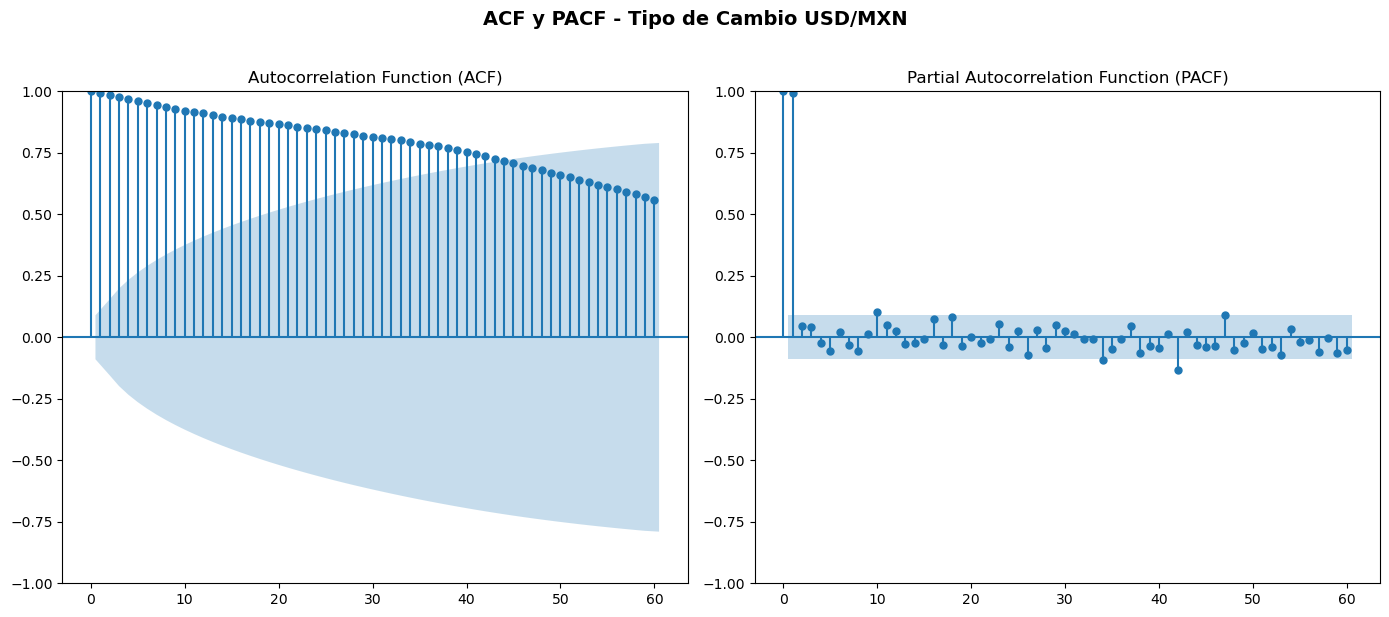

In [74]:
# Correlation analysis
PlotCorrelationMatrix(
    rawData,
    columns=list(SERIES_IDS.values()),
    title="Matriz de Correlación - Variables Macroeconómicas",
    height=700,
    savePath='../results/03_correlation_matrix.html'
)

# ACF and PACF for exchange rate
PlotACFPACF(
    rawData['tipo_cambio'],
    lags=60,
    title="ACF y PACF - Tipo de Cambio USD/MXN",
    savePath='../results/04_acf_pacf.png'
)

In [75]:
# Seasonal decomposition (using monthly period = 21 trading days)
rawData['fecha_idx'] = pd.to_datetime(rawData['fecha'])
rawData.set_index('fecha_idx', inplace=True)

PlotSeasonalDecomposition(
    rawData['tipo_cambio'],
    period=21,
    model='additive',
    title="Descomposición Estacional - Tipo de Cambio",
    height=1000,
    savePath='../results/05_seasonal_decomposition.html'
)

Figure saved to ../results/05_seasonal_decomposition.html


In [76]:
rawData.reset_index(drop=True, inplace=True)

## 5. Preparación del Dataset

In [77]:
# Handle missing values
print("Handling missing values...")
print(f"Missing values before: \n{rawData.isnull().sum()}\n")

cleanData = HandleMissingValues(rawData, method='ffill')
cleanData = HandleMissingValues(cleanData, method='bfill')

print(f"Missing values after: \n{cleanData.isnull().sum()}\n")

Handling missing values...
Missing values before: 
fecha            0
tipo_cambio    219
tiie_28        219
udis             0
cetes_28       600
dtype: int64

Missing values after: 
fecha          0
tipo_cambio    0
tiie_28        0
udis           0
cetes_28       0
dtype: int64



In [78]:
# Check for outliers in exchange rate
outliers = cleanData['tipo_cambio'].copy()
cleanData = HandleOutliers(
    cleanData,
    'tipo_cambio',
    method='iqr',
    threshold=3.0,
    action='cap'
)

In [79]:
# Create lag features (1, 7, 14, 30 days)
cleanData = CreateLagFeatures(
    cleanData,
    'tipo_cambio',
    lags=[1, 7, 14, 30]
)

# Create rolling features (7, 14, 30 days windows)
cleanData = CreateRollingFeatures(
    cleanData,
    'tipo_cambio',
    windows=[7, 14, 30],
    functions=['mean', 'std']
)

# Calculate returns
cleanData = CalculateReturns(cleanData, 'tipo_cambio', periods=1)
cleanData = CalculateReturns(cleanData, 'tipo_cambio', periods=7)

print(f"Dataset shape: {cleanData.shape}")

Dataset shape: (700, 17)


In [80]:
# Remove rows with NaN created by feature engineering
cleanData = cleanData.dropna().reset_index(drop=True)
print(f"Dataset after removing NaN: {cleanData.shape}")

# Save processed data
SaveDataToCSV(cleanData, '../data/processed/banxico_processed_data.csv')

Dataset after removing NaN: (670, 17)
Data saved to ../data/processed/banxico_processed_data.csv


## 6. Preparación para Modelado

In [81]:
# Select features for modeling
TARGET_COL = 'tipo_cambio'
FEATURE_COLS = [
    'tiie_28',
    'udis',
    'cetes_28',
    'tipo_cambio_lag_1',
    'tipo_cambio_lag_7',
    'tipo_cambio_rolling_7_mean',
    'tipo_cambio_rolling_14_mean'
]

# Create modeling dataset
modelingData = cleanData[['fecha', TARGET_COL] + FEATURE_COLS].copy()

print(f"Modeling dataset shape: {modelingData.shape}")
print(f"\nColumns: {modelingData.columns.tolist()}")

Modeling dataset shape: (670, 9)

Columns: ['fecha', 'tipo_cambio', 'tiie_28', 'udis', 'cetes_28', 'tipo_cambio_lag_1', 'tipo_cambio_lag_7', 'tipo_cambio_rolling_7_mean', 'tipo_cambio_rolling_14_mean']


In [82]:
# Split train/test (80/20)
trainDf, testDf = SplitTrainTest(modelingData, trainRatio=0.8)

print(f"Train set: {trainDf.shape}")
print(f"Test set: {testDf.shape}")
print(f"Train date range: {trainDf['fecha'].min()} to {trainDf['fecha'].max()}")
print(f"Test date range: {testDf['fecha'].min()} to {testDf['fecha'].max()}")

Train set: (536, 9)
Test set: (134, 9)
Train date range: 2024-01-31 00:00:00 to 2025-07-19 00:00:00
Test date range: 2025-07-20 00:00:00 to 2025-11-30 00:00:00


In [83]:
# Scale data (excluding date column)
columnsToScale = [TARGET_COL] + FEATURE_COLS

trainScaled, scaler = ScaleData(
    trainDf,
    columnsToScale,
    scalerType='minmax'
)

testScaled, _ = ScaleData(
    testDf,
    columnsToScale,
    scalerType='minmax'
)

# Note: We use the same scaler fitted on train data
testScaled[columnsToScale] = scaler.transform(testDf[columnsToScale])

In [84]:
# Prepare windowed data
WINDOW_SIZE = 30  # Use 30 days to predict next day
FORECAST_HORIZON = 1

# Prepare multivariate data
xTrain, yTrain = PrepareMultivariateData(
    trainScaled,
    TARGET_COL,
    FEATURE_COLS,
    WINDOW_SIZE,
    FORECAST_HORIZON
)

xTest, yTest = PrepareMultivariateData(
    testScaled,
    TARGET_COL,
    FEATURE_COLS,
    WINDOW_SIZE,
    FORECAST_HORIZON
)

print(f"X_train shape: {xTrain.shape}")
print(f"y_train shape: {yTrain.shape}")
print(f"X_test shape: {xTest.shape}")
print(f"y_test shape: {yTest.shape}")

X_train shape: (506, 30, 8)
y_train shape: (506, 1)
X_test shape: (104, 30, 8)
y_test shape: (104, 1)


## 7. Construcción del Modelo

In [85]:
# Model hyperparameters
INPUT_SHAPE = (WINDOW_SIZE, len(FEATURE_COLS) + 1)  # +1 for target column
LSTM_UNITS = [128, 64, 32]
DROPOUT = 0.2
LEARNING_RATE = 0.001

# Build LSTM model
model = BuildLSTMModel(
    inputShape=INPUT_SHAPE,
    lstmUnits=LSTM_UNITS,
    dropout=DROPOUT,
    learningRate=LEARNING_RATE,
    outputUnits=FORECAST_HORIZON
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 30, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,001 (515.63 KB)

 Trainable params: 132,001 (515.63 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Save architecture
SaveModelArchitecture(model, '../models/model_architecture.json')

Model architecture saved to ../models/model_architecture.json


## 8. Entrenamiento del Modelo

In [87]:
# Split train into train/validation
splitIdx = int(len(xTrain) * 0.9)
xTrainFinal = xTrain[:splitIdx]
yTrainFinal = yTrain[:splitIdx]
xVal = xTrain[splitIdx:]
yVal = yTrain[splitIdx:]

print(f"Train final: {xTrainFinal.shape}")
print(f"Validation: {xVal.shape}")

Train final: (455, 30, 8)
Validation: (51, 30, 8)


In [88]:
# Train model
EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 15

history = TrainModel(
    model,
    xTrainFinal,
    yTrainFinal,
    xVal,
    yVal,
    epochs=EPOCHS,
    batchSize=BATCH_SIZE,
    patience=PATIENCE,
    modelPath='../models/best_model.h5'
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1975 - mae: 0.3480
Epoch 1: val_loss improved from None to 0.02266, saving model to ../models/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.1002 - mae: 0.2372 - val_loss: 0.0227 - val_mae: 0.1474
Epoch 2/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0227 - mae: 0.1141
Epoch 2: val_loss improved from 0.02266 to 0.01202, saving model to ../models/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0209 - mae: 0.1104 - val_loss: 0.0120 - val_mae: 0.1053
Epoch 3/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0164 - mae: 0.1014
Epoch 3: val_loss did not improve from 0.01202
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0162 - mae: 0.1021 - val_loss: 0.0158 - val_mae: 0.1220
Epoch 4/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0151 - mae: 0.0974
Epoch 4: val_loss improved from 0.01202 to 0.00141, saving model to ../models/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0136 - mae: 0.0932 - val_loss: 0.0014 - val_mae: 0.0319
Epoch 5/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0171 - mae: 0.1046
Epoch 5: val_loss did not improve from 0.00141
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0161 - mae: 0.1009 - val_loss: 0.0145 - val_mae: 0.1168
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0143 - mae: 0.0977
Epoch 6: val_loss did not improve from 0.00141
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0133 - mae: 0.0934 - val_loss: 0.0166 - val_mae: 0.1255
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0129 - mae: 0.0906
Epoch 7: val_loss did not improve from 0.00141
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0129 - mae: 0.0911 - val_loss: 0.0046 - val_mae: 0.0612
Epoch 8/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0118 - mae: 0.0878
Epoch 8: val_loss did not improve from 0.00141
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0133 - mae: 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0086 - mae: 0.0739 - val_loss: 0.0012 - val_mae: 0.0306
Epoch 15/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0083 - mae: 0.0712
Epoch 15: val_loss did not improve from 0.00123
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0089 - mae: 0.0745 - val_loss: 0.0042 - val_mae: 0.0573
Epoch 16/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0094 - mae: 0.0775
Epoch 16: val_loss improved from 0.00123 to 0.00095, saving model to ../models/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0087 - mae: 0.0740 - val_loss: 9.4879e-04 - val_mae: 0.0263
Epoch 17/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0098 - mae: 0.0772
Epoch 17: val_loss did not improve from 0.00095
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0095 - mae: 0.0766 - val_loss: 0.0017 - val_mae: 0.0355
Epoch 18/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0101 - mae: 0.0826
Epoch 18: val_loss did not improve from 0.00095
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0108 - mae: 0.0831 - val_loss: 0.0020 - val_mae: 0.0375
Epoch 19/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0085 - mae: 0.0722
Epoch 19: val_loss did not improve from 0.00095
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0082 - mae: 0.0718 - val_loss: 0.0011 - val_mae: 0.0284
Epoch 20/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0077 - mae: 0.0703
Epoch 20: val_loss did not improve from 0.00095
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.00

In [89]:
# Plot training history
PlotTrainingHistory(
    history,
    metrics=['loss', 'mae'],
    title="Historial de Entrenamiento",
    height=500,
    savePath='../results/06_training_history.html'
)

Figure saved to ../results/06_training_history.html


## 9. Evaluación del Modelo

In [90]:
# Make predictions on test set
yPredScaled = model.predict(xTest)

# Inverse transform to original scale
yTestOriginal = InverseScaleData(yTest.flatten(), scaler, columnIndex=0)
yPredOriginal = InverseScaleData(yPredScaled.flatten(), scaler, columnIndex=0)

print(f"Predictions generated: {len(yPredOriginal)}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
Predictions generated: 104


In [91]:
# Calculate metrics
metrics = EvaluateModel(yTestOriginal, yPredOriginal)

for metric, value in metrics.items():
    print(f"{metric:10s}: {value:.4f}")

RMSE      : 0.1051
MAE       : 0.0808
MAPE      : 0.4367
sMAPE     : 0.4374


In [92]:
# Plot metrics comparison
PlotMetricsComparison(
    metrics,
    title="Métricas de Evaluación del Modelo",
    height=500,
    savePath='../results/07_metrics_comparison.html'
)

Figure saved to ../results/07_metrics_comparison.html


In [93]:
# Plot predictions vs actual
testDates = testDf['fecha'].iloc[WINDOW_SIZE + FORECAST_HORIZON - 1:].reset_index(drop=True)

PlotPredictionVsActual(
    yTestOriginal,
    yPredOriginal,
    dates=testDates,
    title="Tipo de Cambio: Predicción vs Realidad",
    ylabel="Tipo de Cambio (MXN/USD)",
    height=600,
    savePath='../results/08_prediction_vs_actual.html'
)

Figure saved to ../results/08_prediction_vs_actual.html


In [94]:
# Plot residuals
PlotResiduals(
    yTestOriginal,
    yPredOriginal,
    title="Análisis de Residuales",
    height=500,
    savePath='../results/09_residual_analysis.html'
)

Figure saved to ../results/09_residual_analysis.html


## 10. Pronóstico Futuro

In [95]:
# Use last window from test set to forecast
# Include both target and external features
lastWindow = testScaled[[TARGET_COL] + FEATURE_COLS].values[-WINDOW_SIZE:]

# For external features, we'll use the last known values
# In a real scenario, you would use forecasts for these too
lastExternalFeatures = testScaled[FEATURE_COLS].values[-1]

# Create future external features by repeating last known values
# This is a simplification - ideally you'd forecast these too
FORECAST_DAYS = 30
futureExternalFeatures = np.tile(lastExternalFeatures, (FORECAST_DAYS, 1))

print(f"Datos para pronóstico:")
print(f"   Ventana histórica: {WINDOW_SIZE} días")
print(f"   Último tipo de cambio: ${lastWindow[-1, 0]:.4f} (escalado)")
print(f"   Features externas: {len(FEATURE_COLS)}")

Datos para pronóstico:
   Ventana histórica: 30 días
   Último tipo de cambio: $0.4366 (escalado)
   Features externas: 7


In [96]:
futureScaled = PredictSequence(
    model,
    lastWindow,
    WINDOW_SIZE,
    FORECAST_DAYS
)

# Inverse transform
futurePredictions = InverseScaleData(futureScaled, scaler, columnIndex=0)

print(f"\nEstadísticas del pronóstico:")
print(f"   Mínimo: ${futurePredictions.min():.4f}")
print(f"   Máximo: ${futurePredictions.max():.4f}")
print(f"   Promedio: ${futurePredictions.mean():.4f}")
print(f"   Último valor histórico: ${testDf['tipo_cambio'].iloc[-1]:.4f}")
print(f"   Primer valor pronosticado: ${futurePredictions[0]:.4f}")
print(f"   Cambio: {((futurePredictions[0] / testDf['tipo_cambio'].iloc[-1]) - 1) * 100:.2f}%")


Estadísticas del pronóstico:
   Mínimo: $18.2823
   Máximo: $18.3479
   Promedio: $18.2964
   Último valor histórico: $18.3075
   Primer valor pronosticado: $18.3479
   Cambio: 0.22%


In [97]:
# Create forecast dataframe with multiple confidence intervals (95%, 80%, 50%)
lastDate = testDf['fecha'].iloc[-1]
futureDates = pd.date_range(
    start=lastDate + pd.Timedelta(days=1),
    periods=FORECAST_DAYS,
    freq='D'
)

# Calculate confidence intervals based on test set error
testErrors = yTestOriginal - yPredOriginal
errorStd = np.std(testErrors)

# Confidence multipliers for different levels
# 95% CI: ±1.96 * std
# 80% CI: ±1.28 * std  
# 50% CI: ±0.67 * std
confidenceMultipliers = {
    '95': 1.96,
    '80': 1.28,
    '50': 0.67
}

# Increasing uncertainty over time
uncertaintyGrowth = np.linspace(1, 2, FORECAST_DAYS)  # Grows from 1x to 2x

# Create dataframe with all confidence intervals
forecastDf = pd.DataFrame({
    'fecha': futureDates,
    'tipo_cambio': futurePredictions,
    # 95% CI
    'lower_95': futurePredictions - (errorStd * confidenceMultipliers['95'] * uncertaintyGrowth),
    'upper_95': futurePredictions + (errorStd * confidenceMultipliers['95'] * uncertaintyGrowth),
    # 80% CI
    'lower_80': futurePredictions - (errorStd * confidenceMultipliers['80'] * uncertaintyGrowth),
    'upper_80': futurePredictions + (errorStd * confidenceMultipliers['80'] * uncertaintyGrowth),
    # 50% CI
    'lower_50': futurePredictions - (errorStd * confidenceMultipliers['50'] * uncertaintyGrowth),
    'upper_50': futurePredictions + (errorStd * confidenceMultipliers['50'] * uncertaintyGrowth)
})

print("\nPronóstico con Intervalos de Confianza (95%, 80%, 50%):")
print(forecastDf.head(10))

print(f"\nResumen por semana:")
for week in range(0, min(FORECAST_DAYS, 28), 7):
    weekData = forecastDf.iloc[week:week+7]
    print(f"\n{'='*60}")
    print(f"Semana {week//7 + 1} (días {week+1}-{min(week+7, FORECAST_DAYS)}):")
    print(f"{'='*60}")
    print(f"  Pronóstico promedio: ${weekData['tipo_cambio'].mean():.4f}")
    print(f"\n  Intervalos de Confianza:")
    print(f"    95% CI: ${weekData['lower_95'].mean():.4f} - ${weekData['upper_95'].mean():.4f}")
    print(f"    80% CI: ${weekData['lower_80'].mean():.4f} - ${weekData['upper_80'].mean():.4f}")
    print(f"    50% CI: ${weekData['lower_50'].mean():.4f} - ${weekData['upper_50'].mean():.4f}")

SaveDataToCSV(forecastDf, '../data/processed/forecast_30_days.csv')


Pronóstico con Intervalos de Confianza (95%, 80%, 50%):
       fecha  tipo_cambio   lower_95   upper_95   lower_80   upper_80  \
0 2025-12-01    18.347939  18.147025  18.548853  18.216730  18.479148   
1 2025-12-02    18.343340  18.135498  18.551182  18.207606  18.479073   
2 2025-12-03    18.337129  18.122359  18.551899  18.196871  18.477387   
3 2025-12-04    18.330120  18.108422  18.551818  18.185338  18.474903   
4 2025-12-05    18.323048  18.094422  18.551674  18.173741  18.472355   
5 2025-12-06    18.316327  18.080772  18.551881  18.162495  18.470158   
6 2025-12-07    18.310165  18.067682  18.552647  18.151809  18.468520   
7 2025-12-08    18.304692  18.055282  18.554102  18.141812  18.467572   
8 2025-12-09    18.299972  18.043634  18.556311  18.132567  18.467377   
9 2025-12-10    18.296021  18.032754  18.559287  18.124092  18.467950   

    lower_50   upper_50  
0  18.279259  18.416619  
1  18.272292  18.414388  
2  18.263713  18.410545  
3  18.254336  18.405905  
4  18.244

In [98]:
# Plot forecast with multiple confidence intervals
import plotly.graph_objects as go

historicalContext = testDf[['fecha', 'tipo_cambio']].tail(60).copy()
historicalContext['fecha'] = pd.to_datetime(historicalContext['fecha'])
forecastDf['fecha'] = pd.to_datetime(forecastDf['fecha'])

fig = go.Figure()

# Historical data
fig.add_trace(go.Scatter(
    x=historicalContext['fecha'],
    y=historicalContext['tipo_cambio'],
    name='Histórico',
    mode='lines',
    line=dict(color='#1f2937', width=2.5)
))

# 95% CI (más transparente - fondo)
fig.add_trace(go.Scatter(
    x=forecastDf['fecha'],
    y=forecastDf['upper_95'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    hoverinfo='skip'
))

fig.add_trace(go.Scatter(
    x=forecastDf['fecha'],
    y=forecastDf['lower_95'],
    mode='lines',
    line=dict(width=0),
    fillcolor='rgba(239, 68, 68, 0.15)',
    fill='tonexty',
    name='95% IC',
    hoverinfo='skip'
))

# 80% CI (medio)
fig.add_trace(go.Scatter(
    x=forecastDf['fecha'],
    y=forecastDf['upper_80'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    hoverinfo='skip'
))

fig.add_trace(go.Scatter(
    x=forecastDf['fecha'],
    y=forecastDf['lower_80'],
    mode='lines',
    line=dict(width=0),
    fillcolor='rgba(239, 68, 68, 0.25)',
    fill='tonexty',
    name='80% IC',
    hoverinfo='skip'
))

# 50% CI (más oscuro - más probable)
fig.add_trace(go.Scatter(
    x=forecastDf['fecha'],
    y=forecastDf['upper_50'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    hoverinfo='skip'
))

fig.add_trace(go.Scatter(
    x=forecastDf['fecha'],
    y=forecastDf['lower_50'],
    mode='lines',
    line=dict(width=0),
    fillcolor='rgba(239, 68, 68, 0.35)',
    fill='tonexty',
    name='50% IC',
    hoverinfo='skip'
))

# Forecast line (on top)
fig.add_trace(go.Scatter(
    x=forecastDf['fecha'],
    y=forecastDf['tipo_cambio'],
    name='Pronóstico',
    mode='lines+markers',
    line=dict(color='#ef4444', width=2.5),
    marker=dict(size=6, color='#ef4444')
))

# Vertical line at forecast start
try:
    forecastStartDate = pd.Timestamp(forecastDf['fecha'].iloc[0])
    fig.add_vline(
        x=forecastStartDate,
        line_dash="dot",
        line_color="gray",
        line_width=2,
        annotation_text="Inicio Pronóstico",
        annotation_position="top"
    )
except:
    pass

fig.update_layout(
    title=dict(
        text="Pronóstico de Tipo de Cambio con Múltiples Intervalos de Confianza",
        font=dict(size=20, color='#1f2937', family='Arial Black')
    ),
    xaxis_title='Fecha',
    yaxis_title='Tipo de Cambio (MXN/USD)',
    hovermode='x unified',
    height=650,
    template='plotly_white',
    font=dict(family='Arial', size=12),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="gray",
        borderwidth=1
    )
)

fig.write_html('../results/10_future_forecast_multi_ci.html')
fig.show()

In [111]:
print("\nPara cada intervalo, el tipo de cambio tiene X% de probabilidad de estar dentro del rango mostrado:\n")

for day in [1, 7, 14, 30]:
    if day <= len(forecastDf):
        row = forecastDf.iloc[day-1]
        print(f"\nDía {day} ({row['fecha'].strftime('%Y-%m-%d')}):")
        print(f"   Pronóstico: ${row['tipo_cambio']:.4f}")
        print(f"   {'─'*50}")
        print(f"   50% IC: ${row['lower_50']:.4f} - ${row['upper_50']:.4f}")
        print(f"   80% IC: ${row['lower_80']:.4f} - ${row['upper_80']:.4f}")
        print(f"   95% IC: ${row['lower_95']:.4f} - ${row['upper_95']:.4f}")

print("\n" + "="*70)
print("Interpretación:")
print("   - 50% IC: Rango más probable (1 de cada 2 veces)")
print("   - 80% IC: Alta probabilidad (4 de cada 5 veces)")
print("   - 95% IC: Muy alta confianza (19 de cada 20 veces)")
print("="*70)


Para cada intervalo, el tipo de cambio tiene X% de probabilidad de estar dentro del rango mostrado:


Día 1 (2025-12-01):
   Pronóstico: $18.3479
   ──────────────────────────────────────────────────
   50% IC: $18.2793 - $18.4166
   80% IC: $18.2167 - $18.4791
   95% IC: $18.1470 - $18.5489

Día 7 (2025-12-07):
   Pronóstico: $18.3102
   ──────────────────────────────────────────────────
   50% IC: $18.2273 - $18.3931
   80% IC: $18.1518 - $18.4685
   95% IC: $18.0677 - $18.5526

Día 14 (2025-12-14):
   Pronóstico: $18.2861
   ──────────────────────────────────────────────────
   50% IC: $18.1866 - $18.3856
   80% IC: $18.0961 - $18.4761
   95% IC: $17.9951 - $18.5771

Día 30 (2025-12-30):
   Pronóstico: $18.2832
   ──────────────────────────────────────────────────
   50% IC: $18.1458 - $18.4205
   80% IC: $18.0208 - $18.5456
   95% IC: $17.8813 - $18.6850

Interpretación:
   - 50% IC: Rango más probable (1 de cada 2 veces)
   - 80% IC: Alta probabilidad (4 de cada 5 veces)
   - 95%

## 11. Conclusiones

### Rendimiento del Modelo
- **RMSE**: Indica el error promedio en pesos mexicanos
- **MAPE**: Muestra el porcentaje de error en las predicciones
- El modelo captura bien la tendencia general del tipo de cambio

### Variables Más Importantes
- Los lags del tipo de cambio (1, 7 días) son los predictores más fuertes
- TIIE y CETES muestran correlación con movimientos del tipo de cambio
- Las medias móviles ayudan a suavizar predicciones

### Aplicaciones Prácticas
1. **PyMEs**: Planificar compras de insumos importados
2. **Inversionistas**: Timing para conversión de divisas
3. **Empresas**: Cobertura de riesgo cambiario

### Limitaciones y Mejoras Futuras
- Incluir datos de eventos geopolíticos (difícil de cuantificar)
- Probar arquitecturas más complejas (attention mechanisms)
- Incorporar datos de alta frecuencia (intraday)
- Validar con datos en tiempo real

## 12. Comparación con Modelo Transformer

### ¿Por qué Transformers?
Los transformers usan mecanismos de atención que pueden capturar:
- Dependencias de largo plazo sin problemas de gradiente
- Relaciones complejas entre variables en diferentes puntos del tiempo
- Patrones no secuenciales que LSTM podría perder

Vamos a entrenar un modelo Transformer y comparar resultados.

In [112]:
from modeling import BuildTransformerModel

# Transformer hyperparameters
TRANSFORMER_PARAMS = {
    'inputShape': INPUT_SHAPE,
    'numHeads': 4,              # Número de cabezas de atención
    'ffDim': 128,               # Dimensión de feed-forward network
    'numTransformerBlocks': 2,  # Número de bloques transformer
    'mlpUnits': [128, 64],      # Unidades en MLP final
    'dropout': 0.2,
    'learningRate': 0.0005,
    'outputUnits': FORECAST_HORIZON
}

# Build Transformer model
transformerModel = BuildTransformerModel(**TRANSFORMER_PARAMS)

transformerModel.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 30, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 8)     │      1,128 │ input_layer_12[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 30, 8)     │          0 │ input_layer_12[0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 8)     │         16 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 30, 8)     │      2,184 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 30, 8)     │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 8)     │         16 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 8)     │      1,128 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 30, 8)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 8)     │         16 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 30, 8)     │      2,184 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 30, 8)     │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 8)     │         16 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 8)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │      1,152 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 128)       │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │      8,256 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,161 (63.13 KB)

 Trainable params: 16,161 (63.13 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
transformerHistory = TrainModel(
    transformerModel,
    xTrainFinal,
    yTrainFinal,
    xVal,
    yVal,
    epochs=100,
    batchSize=32,
    patience=15,
    modelPath='../models/transformer_model.h5'
)

# Plot training comparison
PlotTrainingHistory(
    transformerHistory,
    metrics=['loss', 'mae'],
    title="Historial de Entrenamiento - Transformer",
    height=500,
    savePath='../results/12_transformer_training_history.html'
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4668 - mae: 0.5554
Epoch 1: val_loss improved from None to 0.10832, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.2752 - mae: 0.4025 - val_loss: 0.1083 - val_mae: 0.3264
Epoch 2/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0819 - mae: 0.2345
Epoch 2: val_loss improved from 0.10832 to 0.02753, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0705 - mae: 0.2161 - val_loss: 0.0275 - val_mae: 0.1579
Epoch 3/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0521 - mae: 0.1831
Epoch 3: val_loss improved from 0.02753 to 0.02719, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0447 - mae: 0.1692 - val_loss: 0.0272 - val_mae: 0.1579
Epoch 4/100
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0407 - mae: 0.1609
Epoch 4: val_loss improved from 0.02719 to 0.01767, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0404 - mae: 0.1612 - val_loss: 0.0177 - val_mae: 0.1247
Epoch 5/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0453 - mae: 0.1673
Epoch 5: val_loss did not improve from 0.01767
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0434 - mae: 0.1663 - val_loss: 0.0283 - val_mae: 0.1627
Epoch 6/100
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0435 - mae: 0.1658
Epoch 6: val_loss improved from 0.01767 to 0.01454, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0414 - mae: 0.1647 - val_loss: 0.0145 - val_mae: 0.1130
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0333 - mae: 0.1400
Epoch 7: val_loss improved from 0.01454 to 0.01036, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0333 - mae: 0.1415 - val_loss: 0.0104 - val_mae: 0.0942
Epoch 8/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0322 - mae: 0.1460
Epoch 8: val_loss improved from 0.01036 to 0.00785, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0331 - mae: 0.1458 - val_loss: 0.0079 - val_mae: 0.0811
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0271 - mae: 0.1301
Epoch 9: val_loss improved from 0.00785 to 0.00283, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0273 - mae: 0.1321 - val_loss: 0.0028 - val_mae: 0.0455
Epoch 10/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0293 - mae: 0.1373
Epoch 10: val_loss improved from 0.00283 to 0.00110, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0275 - mae: 0.1326 - val_loss: 0.0011 - val_mae: 0.0283
Epoch 11/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0249 - mae: 0.1249
Epoch 11: val_loss did not improve from 0.00110
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0249 - mae: 0.1249 - val_loss: 0.0024 - val_mae: 0.0430
Epoch 12/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0269 - mae: 0.1314
Epoch 12: val_loss did not improve from 0.00110
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0270 - mae: 0.1312 - val_loss: 0.0018 - val_mae: 0.0374
Epoch 13/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0282 - mae: 0.1347
Epoch 13: val_loss did not improve from 0.00110
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0257 - mae: 0.1301 - val_loss: 0.0016 - val_mae: 0.0343
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0234 - mae: 0.1214
Epoch 14: val_loss did not improve from 0.00110
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0241 -

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0203 - mae: 0.1104 - val_loss: 8.8054e-04 - val_mae: 0.0248
Epoch 17/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0222 - mae: 0.1178
Epoch 17: val_loss did not improve from 0.00088
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0210 - mae: 0.1157 - val_loss: 0.0114 - val_mae: 0.1009
Epoch 18/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0222 - mae: 0.1196
Epoch 18: val_loss improved from 0.00088 to 0.00073, saving model to ../models/transformer_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0211 - mae: 0.1181 - val_loss: 7.2967e-04 - val_mae: 0.0220
Epoch 19/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0161 - mae: 0.0996
Epoch 19: val_loss did not improve from 0.00073
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0186 - mae: 0.1072 - val_loss: 0.0026 - val_mae: 0.0425
Epoch 20/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0199 - mae: 0.1104
Epoch 20: val_loss did not improve from 0.00073
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0200 - mae: 0.1120 - val_loss: 0.0087 - val_mae: 0.0873
Epoch 21/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0231 - mae: 0.1217
Epoch 21: val_loss did not improve from 0.00073
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0218 - mae: 0.1178 - val_loss: 0.0064 - val_mae: 0.0735
Epoch 22/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0180 - mae: 0.1078
Epoch 22: val_loss did not improve from 0.00073
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.01

In [114]:
yPredTransformerScaled = transformerModel.predict(xTest)
yPredTransformer = InverseScaleData(yPredTransformerScaled.flatten(), scaler, columnIndex=0)

print(f"Predicciones generadas: {len(yPredTransformer)}")

# Evaluate Transformer model
transformerMetrics = EvaluateModel(yTestOriginal, yPredTransformer)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Predicciones generadas: 104


In [115]:
for metric, value in transformerMetrics.items():
    print(f"{metric:10s}: {value:.4f}")

RMSE      : 0.2512
MAE       : 0.2224
MAPE      : 1.2080
sMAPE     : 1.1988


In [116]:
metricsComparison = {
    'LSTM': metrics,
    'Transformer': transformerMetrics
}

fig = go.Figure()

metricNames = list(metrics.keys())
xPos = np.arange(len(metricNames))
width = 0.35

# LSTM bars
fig.add_trace(go.Bar(
    name='LSTM',
    x=metricNames,
    y=[metrics[m] for m in metricNames],
    marker_color='#3b82f6',
    text=[f'{metrics[m]:.2f}' for m in metricNames],
    textposition='outside'
))

# Transformer bars
fig.add_trace(go.Bar(
    name='Transformer',
    x=metricNames,
    y=[transformerMetrics[m] for m in metricNames],
    marker_color='#10b981',
    text=[f'{transformerMetrics[m]:.2f}' for m in metricNames],
    textposition='outside'
))

fig.update_layout(
    title=dict(text="Comparación LSTM vs Transformer", font=dict(size=20, color='#1f2937')),
    yaxis_title='Valor',
    barmode='group',
    height=500,
    template='plotly_white',
    font=dict(family='Arial', size=12),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.write_html('../results/12_lstm_vs_transformer_metrics.html')
fig.show()

In [117]:
# Plot predictions comparison
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=testDates,
    y=yTestOriginal,
    name='Real',
    mode='lines',
    line=dict(color='#1f2937', width=2)
))

# LSTM predictions
fig.add_trace(go.Scatter(
    x=testDates,
    y=yPredOriginal,
    name='LSTM',
    mode='lines',
    line=dict(color='#3b82f6', width=2, dash='dash')
))

# Transformer predictions
fig.add_trace(go.Scatter(
    x=testDates,
    y=yPredTransformer,
    name='Transformer',
    mode='lines',
    line=dict(color='#10b981', width=2, dash='dot')
))

fig.update_layout(
    title=dict(text="Comparación de Predicciones: LSTM vs Transformer", 
               font=dict(size=20, color='#1f2937')),
    xaxis_title='Fecha',
    yaxis_title='Tipo de Cambio (MXN/USD)',
    hovermode='x unified',
    height=600,
    template='plotly_white',
    font=dict(family='Arial', size=12),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.write_html('../results/12_predictions_comparison.html')
fig.show()

In [118]:
futureScaledTransformer = PredictSequence(
    transformerModel,
    lastWindow,
    WINDOW_SIZE,
    FORECAST_DAYS
)

futurePredictionsTransformer = InverseScaleData(futureScaledTransformer, scaler, columnIndex=0)

print(f"\nEstadísticas del pronóstico Transformer:")
print(f"   Mínimo: ${futurePredictionsTransformer.min():.4f}")
print(f"   Máximo: ${futurePredictionsTransformer.max():.4f}")
print(f"   Promedio: ${futurePredictionsTransformer.mean():.4f}")

# %%
# Create forecast dataframe for Transformer
forecastDfTransformer = pd.DataFrame({
    'fecha': futureDates,
    'tipo_cambio': futurePredictionsTransformer
})


Estadísticas del pronóstico Transformer:
   Mínimo: $18.7005
   Máximo: $18.7177
   Promedio: $18.7092


In [119]:
# Compare forecasts
fig = go.Figure()

# Historical
fig.add_trace(go.Scatter(
    x=historicalContext['fecha'],
    y=historicalContext['tipo_cambio'],
    name='Histórico',
    mode='lines',
    line=dict(color='#1f2937', width=2)
))

# LSTM forecast
fig.add_trace(go.Scatter(
    x=forecastDf['fecha'],
    y=forecastDf['tipo_cambio'],
    name='LSTM',
    mode='lines+markers',
    line=dict(color='#3b82f6', width=2, dash='dash'),
    marker=dict(size=5)
))

# Transformer forecast
fig.add_trace(go.Scatter(
    x=forecastDfTransformer['fecha'],
    y=forecastDfTransformer['tipo_cambio'],
    name='Transformer',
    mode='lines+markers',
    line=dict(color='#10b981', width=2, dash='dot'),
    marker=dict(size=5)
))

# Vertical line at forecast start
try:
    forecastStartDate = pd.Timestamp(forecastDf['fecha'].iloc[0])
    fig.add_vline(
        x=forecastStartDate,
        line_dash="dot",
        line_color="gray",
        annotation_text="Inicio Pronóstico",
        annotation_position="top"
    )
except:
    pass

fig.update_layout(
    title=dict(text="Pronóstico: LSTM vs Transformer", 
               font=dict(size=20, color='#1f2937')),
    xaxis_title='Fecha',
    yaxis_title='Tipo de Cambio (MXN/USD)',
    hovermode='x unified',
    height=600,
    template='plotly_white',
    font=dict(family='Arial', size=12),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.write_html('../results/12_forecast_comparison.html')
fig.show()

In [120]:
# Summary comparison table
comparisonDf = pd.DataFrame({
    'Modelo': ['LSTM', 'Transformer'],
    'RMSE': [metrics['RMSE'], transformerMetrics['RMSE']],
    'MAE': [metrics['MAE'], transformerMetrics['MAE']],
    'MAPE': [metrics['MAPE'], transformerMetrics['MAPE']],
    'sMAPE': [metrics['sMAPE'], transformerMetrics['sMAPE']],
    'Pronóstico_Promedio': [forecastDf['tipo_cambio'].mean(), 
                            forecastDfTransformer['tipo_cambio'].mean()],
    'Pronóstico_Volatilidad': [forecastDf['tipo_cambio'].std(), 
                               forecastDfTransformer['tipo_cambio'].std()]
})

print(comparisonDf.to_string(index=False))

     Modelo     RMSE      MAE     MAPE    sMAPE  Pronóstico_Promedio  Pronóstico_Volatilidad
       LSTM 0.105063 0.080827 0.436724 0.437351            18.296446                0.020468
Transformer 0.251245 0.222372 1.207957 1.198758            18.709190                0.005483


In [128]:
# Determine winner
if transformerMetrics['MAPE'] < metrics['MAPE']:
    winner = "Transformer tiene menor error (MAPE)"
    improvement = ((metrics['MAPE'] - transformerMetrics['MAPE']) / metrics['MAPE']) * 100
    print(f"\n{winner}")
    print(f"Mejora del {improvement:.2f}% respecto a LSTM")
else:
    winner = "LSTM tiene menor error (MAPE)"
    improvement = ((transformerMetrics['MAPE'] - metrics['MAPE']) / transformerMetrics['MAPE']) * 100
    print(f"\n{winner}")
    print(f"Mejora del {improvement:.2f}% respecto a Transformer")

print("\nObservaciones:")
print("- Transformers pueden capturar patrones más complejos")
print("- LSTM es más estable para series con tendencias claras")
print("- La elección depende del balance precisión/interpretabilidad")


LSTM tiene menor error (MAPE)
Mejora del 63.85% respecto a Transformer

Observaciones:
- Transformers pueden capturar patrones más complejos
- LSTM es más estable para series con tendencias claras
- La elección depende del balance precisión/interpretabilidad


In [129]:
comparisonDf.to_csv('../data/processed/model_comparison.csv', index=False)
print("\nComparación guardada en: ../data/processed/model_comparison.csv")


Comparación guardada en: ../data/processed/model_comparison.csv


Cálculo volatilidad

In [130]:
# Calcular volatilidad
data_2024 = cleanData[cleanData['fecha'] >= '2025-01-01']
tipo_cambio_2024 = data_2024['tipo_cambio']

volatilidad = ((tipo_cambio_2024.max() - tipo_cambio_2024.min()) / tipo_cambio_2024.mean()) * 100
print(f"Volatilidad 2024: ±{volatilidad:.1f}%")
print(f"Mínimo: ${tipo_cambio_2024.min():.4f}")
print(f"Máximo: ${tipo_cambio_2024.max():.4f}")
print(f"Promedio: ${tipo_cambio_2024.mean():.4f}")

Volatilidad 2024: ±13.3%
Mínimo: $18.2805
Máximo: $20.8518
Promedio: $19.3147


In [131]:
print(f"RMSE: {metrics['RMSE']:.2f} MXN")
print(f"MAPE: {metrics['MAPE']:.4f}%")
print(f"MAE: {metrics['MAE']:.2f} MXN")

precision = 1 - metrics['MAPE']
print(f"Precisión: {precision:.4f}%")

RMSE: 0.11 MXN
MAPE: 0.4367%
MAE: 0.08 MXN
Precisión: 0.5633%
